# GDAL Mosaic Access via Signed URL
Bare-bones self-contained example of accessing the EarthDaily mosaics via an S3 signed URL (obtained through the UI)

## How to Use
1. Update the configuration variables to match your preferred settings 
2. Select a AOI with the Rectangle tool in the preview map.
3. Call GDAL to download the selected region. NOTE: The downloaded file size can get very large very quickly. If downloading is taking too long, try selecting a smaller region or using a coarser resolution
4. Explore preview plots of GeoTIFF with unscaled DN values with rasterio and simple NDVI calculation

**Use of the EarthDaily mosaics is subject to the license agreement at https://mosaics-preview.earthdaily.com/home**

## Setup

In [22]:
import sys
import os
sys.path.insert(0, os.path.abspath('.'))

from datetime import datetime, timedelta
from urllib.parse import urlparse, parse_qs

import numpy as np
import rasterio
from osgeo import gdal 

import plotting_utils

## Configuration

In [ ]:
# Login to https://mosaics-preview.earthdaily.com/home/login to obtain the signed URL
SIGNED_URL = '<COPY_AND_PASTE_FROM_MOSAICS_UI>'

# Path with sufficient space to write the output imagery
OUT_PATH = './retrieved_imagery.tif'

# Output pixel spacing (10m is full resolution)
OUTPUT_SPACING_METRES = 10

# Display information about the mosaic
gdal.Info(f'/vsicurl/{SIGNED_URL}', format='json')

In [25]:
print(f"Current time is:       {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")
try:
    # Signature Version 2 has expiry date included
    print(f"Signed URL expires at: {datetime.utcfromtimestamp(int(parse_qs(urlparse(SIGNED_URL).query)['Expires'][0]))} UTC") 
except: 
    # Signature Version 4 has creation date + expiry time included
    print(f"Signed URL expires at: {datetime.strptime(parse_qs(urlparse(SIGNED_URL).query)['X-Amz-Date'][0], '%Y%m%dT%H%M%SZ') + timedelta(seconds=int(parse_qs(urlparse(SIGNED_URL).query)['X-Amz-Expires'][0]))} UTC") 

Current time is:       2021-06-18 02:51:10 UTC
Signed URL expires at: 2021-06-25 02:34:40 UTC


# Retrieve Mosaic Data Over AOI
To select a rectangular AOI: 
- Navigate within the map to your desired area within British Columbia
- Click the black square (third button from the top)
- Click and drag to select your desired AOI
- Run the next cell to retrieve your selected AOI as latitude/longitude corners

**Note: Start with a small AOI, as the entire mosaic is very large at full resolution! For example, all 4 bands of the City of Vancouver at full resolution is about 85MB.**

In [26]:
# Select AOI within British Columbia
preview_map = plotting_utils.PreviewMap()
preview_map.get_map(center=[55.25, -123.25], 
                    zoom=5, 
                    polygon_for_footprint=[(48.3, -129.9,), (48.3, -112.5), (53.8, -119.9), (60.0, -119.9), (60.0, -141.0), (48.3, -129.9)])

Map(center=[55.25, -123.25], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [27]:
geo_aoi = preview_map.get_selected_lat_lon_corners()
print(f'Selected AOI: {geo_aoi}')

Selected AOI: {'ul_lat': 49.222432, 'ul_lng': -123.22918, 'lr_lat': 49.167425, 'lr_lng': -123.111124}


In [ ]:
# Download all bands into a file, resampled to UTM projection. The mosaic has bands: BLUE, GREEN, RED, NIR
# If this fails, double-check that your signed URL has not expired, and try obtaining a new one

# The source is a Cloud-Optimized Geotiff, so GDAL will automatically choose the most appropriate subsampled 
# overview level for the specified output spacing and only read the regions specified by the selected AOI. 
ds = gdal.Warp(OUT_PATH, gdal.Open(f'/vsicurl/{SIGNED_URL}'),
               outputBounds=[geo_aoi['ul_lng'], geo_aoi['lr_lat'], geo_aoi['lr_lng'], geo_aoi['ul_lat']],
               outputBoundsSRS='EPSG:4326',
               dstSRS=preview_map.get_selected_utm_epsg(),
               xRes=OUTPUT_SPACING_METRES,
               yRes=OUTPUT_SPACING_METRES,
               resampleAlg='cubic')               
ds = None
gdal.Info(OUT_PATH, format='json')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


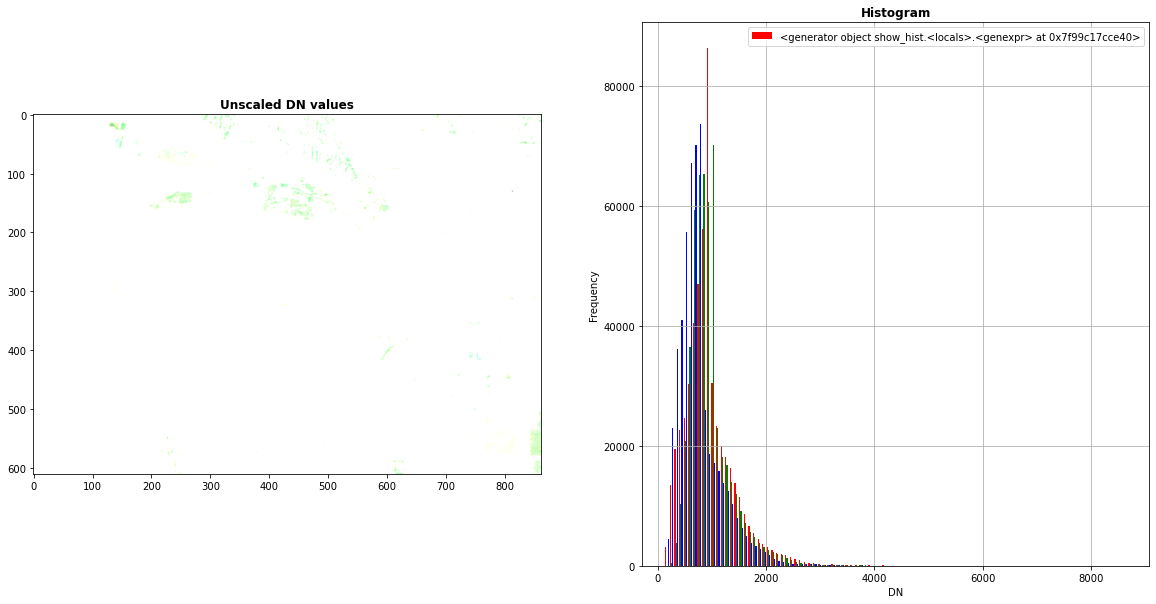

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


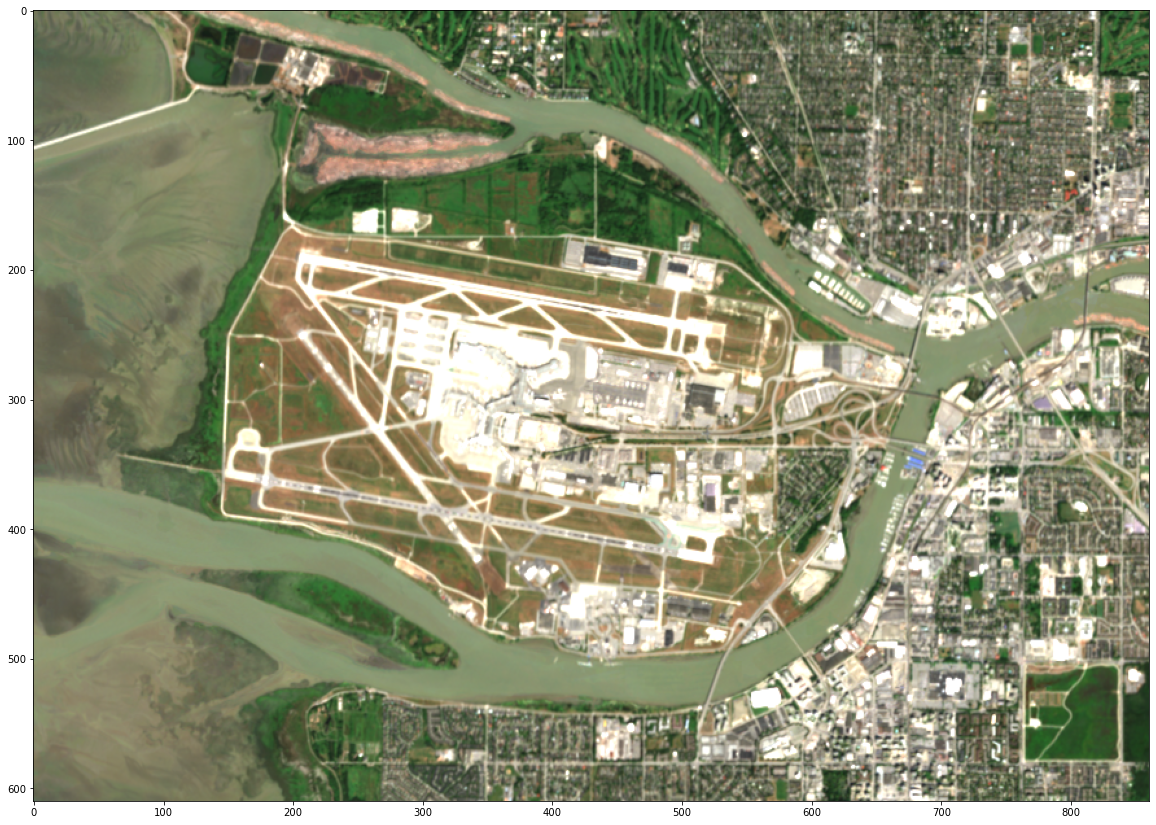

In [31]:
# Read in and display the downloaded imagery
# Plot bands RED, GREEN, BLUE
plotting_utils.plot_data(OUT_PATH, ['RED', 'GREEN', 'BLUE'], show_bands=[3, 2, 1])

# Simple NDVI Calculation Example

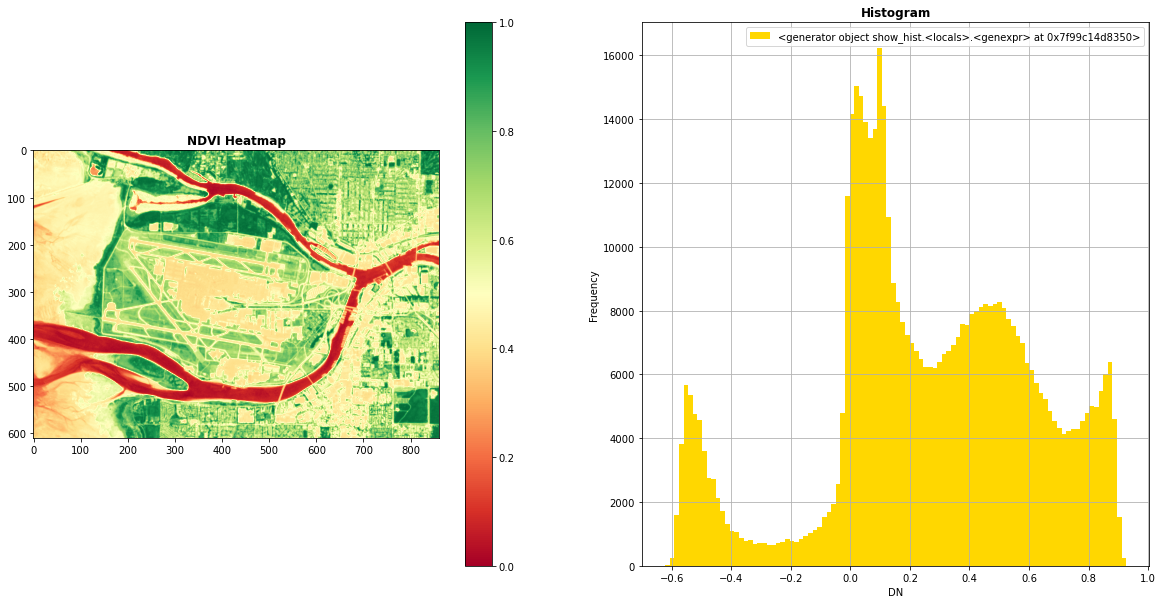

In [32]:
from matplotlib import cm
import matplotlib.pyplot as plt
from rasterio.plot import show_hist, show

color_map = 'RdYlGn'

# Read in RED and NIR band data. Band order is BGRN
ds = gdal.Open(OUT_PATH, gdal.GA_ReadOnly)
red = ds.GetRasterBand(3).ReadAsArray().astype('float')
nir = ds.GetRasterBand(4).ReadAsArray().astype('float')

# Calculate NDVI
ndvi = (nir - red)/(nir + red)

# Plot NDVI and histogram
fig, (ax_ndvi, ax_hist) = plt.subplots(1, 2, figsize=(20,10))
show(ndvi, ax=ax_ndvi, title='NDVI Heatmap', cmap=color_map)
fig.colorbar(cm.ScalarMappable(cmap=color_map), ax=ax_ndvi)
show_hist(ndvi, bins=100, ax=ax_hist)
plt.show()